In [1]:
import tensorflow as tf
import numpy as py
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import urllib.request
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
dataset_url='https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv'
dataset_dir='./datasets/'
dataset_path='datasets/titanic3.csv'

os.makedirs(dataset_dir) if not os.path.exists(dataset_dir) else None
if not os.path.isfile(dataset_path):
    result=urllib.request.urlretrieve(dataset_url,dataset_path)
    print('dataset does not exist, downloading it now:',result)
else: print(dataset_path,'dataset found!')

model_log_dir='./model_logs/'
model_ckpt_dir='./model_ckpt/'
model_ckpt_path='./model_ckpt/titanic.ckpt'

os.makedirs(model_log_dir) if not os.path.exists(model_log_dir) else None
os.makedirs(model_ckpt_dir) if not os.path.exists(model_ckpt_dir) else None

datasets/titanic3.csv dataset found!


In [3]:
df=pd.read_csv(dataset_path)
selected_cols=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
df_selected=df[selected_cols]

'''
df_selected.isnull().sum()
df_selected[df_selected.isnull().values==True]
'''

'\ndf_selected.isnull().sum()\ndf_selected[df_selected.isnull().values==True]\n'

In [4]:
df_selected=df_selected.sample(frac=1)
df_selected['age']=df_selected['age'].fillna(df_selected['age'].mean())
df_selected['fare']=df_selected['fare'].fillna(df_selected['fare'].mean())
df_selected['embarked']=df_selected['embarked'].fillna('S')
df_selected['embarked']=df_selected['embarked'].map({'C':0,'Q':1,'S':2}).astype(int)
df_selected['sex']=df_selected['sex'].map({'female':0,'male':1}).astype(int)
df_selected=df_selected.drop(['name'],axis=1)

In [5]:
feature=df_selected.values[:,1:]
label=df_selected.values[:,0]
feature=preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(feature)

train_num=int(len(feature)*0.8)
train_feature=feature[:train_num]
train_label=label[:train_num]
test_feature=feature[train_num:]
test_label=label[train_num:]

In [6]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64,input_dim=7,use_bias=True,kernel_initializer='uniform',bias_initializer='zeros',activation='relu'))
model.add(tf.keras.layers.Dense(units=32,activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.003),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [7]:
callbacks=[tf.keras.callbacks.TensorBoard(log_dir=model_log_dir,histogram_freq=2),
           tf.keras.callbacks.ModelCheckpoint(filepath=model_ckpt_path,save_weights_only=True,verbose=0,period=50)]

if not os.path.isfile(model_ckpt_path+'.index'):
    train_history=model.fit(x=train_feature,y=train_label,validation_split=0.2,epochs=100,batch_size=50,callbacks=callbacks,verbose=0)
    print('model ckpt file does not exist, training and saving it now...')
else:
    model.load_weights(tf.train.latest_checkpoint(model_ckpt_dir))
    print('model ckpt file found! load the weight into model...')

model ckpt file does not exist, training and saving it now...


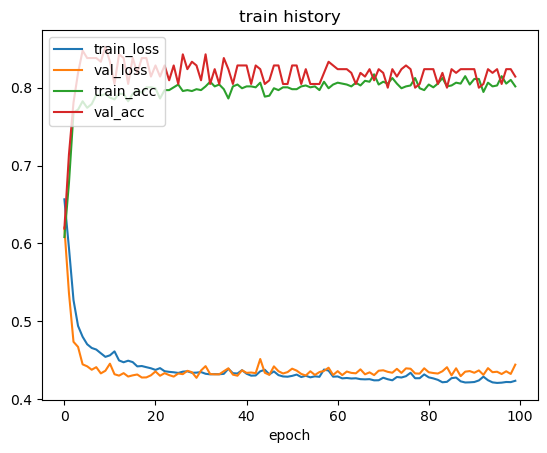

In [8]:
def show_train_history(train_history,train_loss,val_loss,train_acc,val_acc):
    plt.plot(train_history.history[train_loss])
    plt.plot(train_history.history[val_loss])
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[val_acc])
    plt.title('train history')
    plt.xlabel('epoch')
    plt.legend(['train_loss','val_loss','train_acc','val_acc'],loc='upper left')
    plt.show()

show_train_history(train_history,'loss','val_loss','accuracy','val_accuracy')

In [9]:
test_loss,test_acc=model.evaluate(x=test_feature,y=test_label)

9/9 [==============================] - 0s 938us/step - loss: 0.4828 - accuracy: 0.7672


In [10]:
surv_probability=model.predict(feature)
df_selected.insert(len(df_selected.columns),'surv_probability',surv_probability)
df_selected.head(5)

41/41 [==============================] - 0s 568us/step


,survived,pclass,sex,age,sibsp,parch,fare,embarked,surv_probability
427,1,2,1,0.670000,1,1,14.5000,2,0.620201
1167,0,3,1,29.881138,0,0,7.7292,1,0.141167
1070,0,3,1,29.881138,0,0,7.8292,1,0.141121
667,0,3,0,27.000000,0,0,7.8792,1,0.602263
507,0,2,1,27.000000,0,0,13.0000,2,0.203864
